<a href="https://colab.research.google.com/github/aytlee/kaggle-tabular-playground-apr2022/blob/main/time_series_lstm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle - Tabular Playground Series - Apr 2022

The Kaggle dataset contains thousands of 60s sequences of biological sensor data who have been in either of two possible activity states. 
Purpose of the challenge is to take this time series data and predict the state of the participant. 

For this challenge, will attempt using a LSTM built using PyTorch to predict the states.


In [ ]:
import os 
import pandas as pd 
import numpy as np
from sklearn import model_selection 

import torch
import torch.autograd as autogra
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 

import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib import rc 
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from multiprocessing import cpu_count
from sklearn.metrics import classification_report, confusion_matrix 

import plotly.graph_objects as go

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# read in files
train_data = pd.read_csv(r'./train.csv')
train_labels = pd.read_csv(r'./train_labels.csv')
test_data = pd.read_csv(r'./test.csv')

In [ ]:
print('Shape of the training set:', train_data.shape)
print('Size of the training labels:', train_labels.shape)

train_labels['state'].value_counts(normalize=True)

Shape of the training set: (1558080, 16)
Size of the training labels: (25968, 2)


1    0.501155
0    0.498845
Name: state, dtype: float64

In [ ]:
data = train_data.merge(train_labels, how='left', left_on=['sequence'], 
                        right_on=['sequence']).drop_duplicates()

data.describe()


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
count,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06
mean,1.298350e+04,3.316331e+02,2.950000e+01,4.365526e-04,-1.034982e-03,-2.178045e-01,-2.156555e-03,-1.828903e-03,-1.651785e-03,-4.122917e-04,-2.620665e-05,-1.298393e-04,1.365584e-03,3.315801e-04,-3.733291e-03,-1.172605e-02,5.011553e-01
std,7.496318e+03,1.958257e+02,1.731811e+01,2.658684e+00,4.404200e+00,2.298002e+00,3.934184e+00,1.683685e+00,1.590818e+00,3.345143e+00,3.243428e+00,4.501534e+00,2.592913e+00,1.917333e+00,4.532568e+00,3.911767e+01,4.999988e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.750634e+02,-4.345977e+02,-3.165948e+01,-4.083761e+02,-2.362601e+01,-7.498280e+01,-4.705046e+02,-4.070115e+02,-5.361000e+02,-2.703468e+02,-4.341271e+01,-4.270586e+02,-6.125494e+02,0.000000e+00
25%,6.491750e+03,1.617500e+02,1.475000e+01,-5.000000e-01,-4.831933e-01,-6.461531e-01,-4.929204e-01,-4.729928e-01,-4.786836e-01,-4.927140e-01,-5.022901e-01,-5.000000e-01,-5.151734e-01,-4.787939e-01,-4.835391e-01,-5.805627e-01,0.000000e+00
50%,1.298350e+04,3.350000e+02,2.950000e+01,-3.091190e-03,3.151261e-03,0.000000e+00,0.000000e+00,-1.589577e-03,2.991773e-03,9.107468e-04,-2.290076e-03,0.000000e+00,-1.445087e-03,-1.655822e-03,3.086420e-03,0.000000e+00,1.000000e+00
75%,1.947525e+04,5.010000e+02,4.425000e+01,4.845440e-01,4.926471e-01,3.338469e-01,4.893805e-01,4.701565e-01,5.056096e-01,4.927140e-01,4.847328e-01,5.000000e-01,5.086705e-01,4.780386e-01,4.938272e-01,5.703325e-01,1.000000e+00
max,2.596700e+04,6.710000e+02,5.900000e+01,3.358246e+02,4.495914e+02,1.666667e+00,4.366504e+02,2.487286e+01,7.791548e+01,4.425009e+02,3.312542e+02,6.301000e+02,3.679812e+02,4.186559e+01,4.480206e+02,6.305111e+02,1.000000e+00


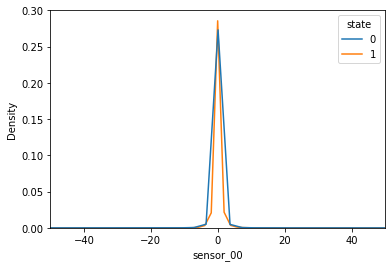

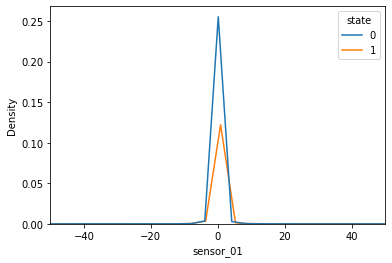

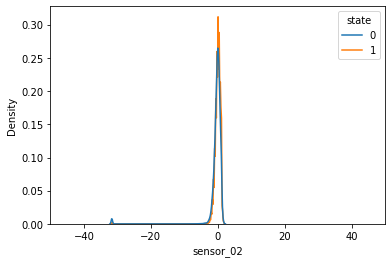

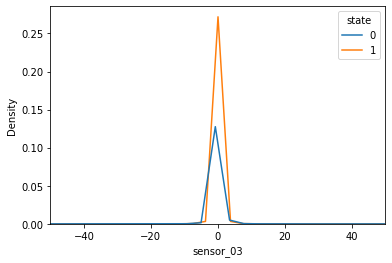

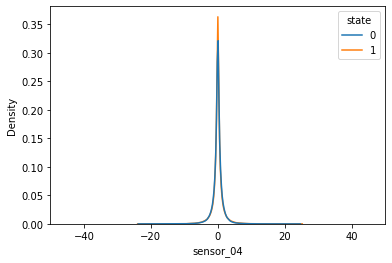

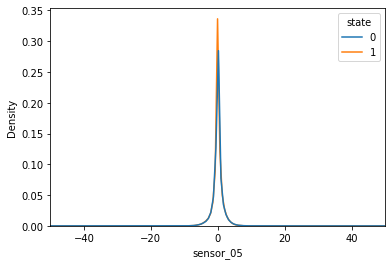

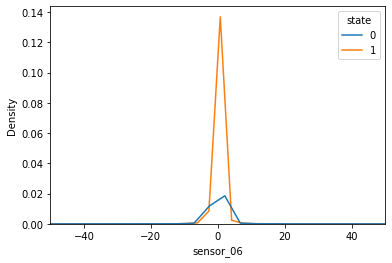

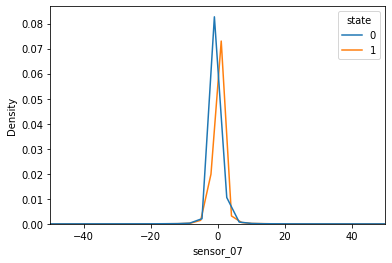

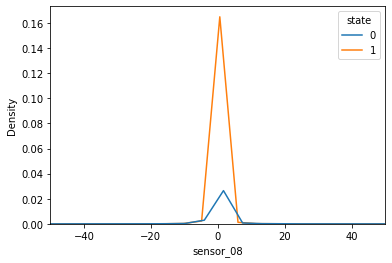

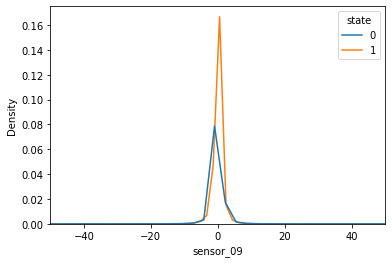

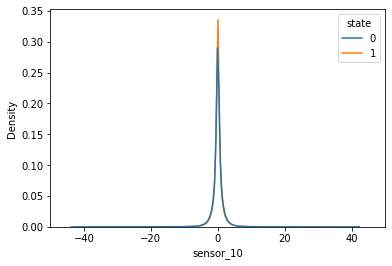

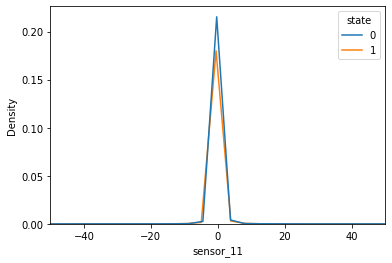

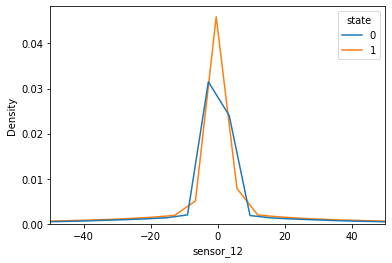

In [ ]:
import seaborn as sns 
from matplotlib import pyplot as plt 

sensor_list = [col for col in data if col.startswith('sensor')]
#for sensor in sensor_list:
#fig, axes = plt.subplots(len(sensor_list), 2)
for sensor in sensor_list:
  fig, ax = plt.subplots()
  sns.kdeplot(data=data, x=sensor, hue='state', ax=ax)
  #sns.histplot(data=data, x=sensor_list[i], hue='state', ax= axes[i, 1])
  ax.set_xlim(-50, 50)
  plt.show()

# sns.kdeplot(data=data, x=sensor, hue='state', ax = ax)
# ax.set_xlim(-50, 50)
# plt.show()

In [ ]:
# Check the mean and median values for each sensor and state to see if there is a major difference 
# for each sensor and step, calculate the average and the median, and plot it by state 

import plotly.express as px

df_mean = data.groupby(['state', 'step']).agg({
    'sensor_00':'mean',
    'sensor_01':'mean',
    'sensor_02':'mean',
    'sensor_03':'mean',
    'sensor_04':'mean',
    'sensor_05':'mean', 
    'sensor_06':'mean',
    'sensor_07':'mean',
    'sensor_08':'mean', 
    'sensor_09':'mean', 
    'sensor_10':'mean', 
    'sensor_11':'mean',
    'sensor_12':'mean'
}).reset_index()

mean_names = [sensor+'_mean' for sensor in sensor_list]
df_mean.columns = ['state', 'step'] + mean_names

df_mean

,state,step,sensor_00_mean,sensor_01_mean,sensor_02_mean,sensor_03_mean,sensor_04_mean,sensor_05_mean,sensor_06_mean,sensor_07_mean,sensor_08_mean,sensor_09_mean,sensor_10_mean,sensor_11_mean,sensor_12_mean
0,0,0,0.037033,0.001701,-0.419231,-0.046416,-0.027352,0.031545,0.061142,-0.011385,-0.050841,0.038946,-0.000320,-0.034275,-0.639378
1,0,1,0.014746,-0.015674,-0.411605,0.018340,-0.032046,-0.002859,0.015104,0.009938,0.006994,0.002773,-0.003391,0.029953,-0.953282
2,0,2,-0.069077,-0.023903,-0.404421,-0.042995,-0.001818,-0.006533,-0.074282,-0.035389,-0.033835,-0.037471,-0.017014,0.042053,-0.030742
3,0,3,0.043787,-0.000400,-0.405774,0.019730,0.008947,0.016626,0.030106,0.054508,0.063803,0.006616,-0.018631,-0.035374,0.633535
4,0,4,0.052467,0.077276,-0.411802,-0.020689,-0.018405,-0.022487,0.020531,-0.001482,-0.023298,0.025162,0.001015,-0.061061,0.416014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,55,0.034171,-0.040395,-0.033361,-0.025959,0.000488,-0.015079,0.011705,-0.012788,-0.038120,0.020940,0.010604,-0.105915,0.008791
116,1,56,-0.039535,-0.021317,-0.029224,0.036611,0.017153,-0.008619,-0.065405,0.041002,-0.060389,-0.025697,0.011304,-0.012750,0.369856
117,1,57,0.008683,0.009874,-0.021679,-0.020245,0.002066,0.007569,0.039495,-0.030134,0.030575,0.014499,-0.015751,0.004604,0.306788
118,1,58,0.004504,-0.005815,-0.020532,-0.002783,0.015640,-0.011721,-0.001979,-0.010687,-0.047656,-0.014042,-0.029418,0.019921,-0.565397


In [ ]:
import plotly.express as px 

for sensor in sensor_list:
  fig = px.bar(df_mean, x = 'step', y=sensor+'_mean', color='state', 
               title='Average value for '+ sensor+ ' at each time step')
  fig.show()

In [ ]:
# Check the mean and median values for each sensor and state to see if there is a major difference 
# for each sensor and step, calculate the average and the median, and plot it by state 

import plotly.express as px

df_median = data.groupby(['state', 'step']).agg({
    'sensor_00':'median',
    'sensor_01':'median',
    'sensor_02':'median',
    'sensor_03':'median',
    'sensor_04':'median',
    'sensor_05':'median', 
    'sensor_06':'median',
    'sensor_07':'median',
    'sensor_08':'median', 
    'sensor_09':'median', 
    'sensor_10':'median', 
    'sensor_11':'median',
    'sensor_12':'median'
}).reset_index()

median_names = [sensor+'_median' for sensor in sensor_list]
df_median.columns = ['state', 'step'] + median_names


In [ ]:
import plotly.express as px 

for sensor in sensor_list:
  fig = px.bar(df_median, x = 'step', y=sensor+'_median', color='state', 
               title='Median value for '+ sensor+ ' at each time step')
  fig.show()

For the averaged values, the sensor values do not seem to show a clear distinct trend. However, for the median values, some sensors do seem to indicate that for certain states, the values are either more negative or positive. For sensors 2 and 8, the median values are zero throughout. 

In [ ]:
def process_data(df):
  sensor_list = [col for col in df if col.startswith('sensor')]
  features = pd.DataFrame()

  for sensor in sensor_list:
    df_grp = df.groupby(['sequence'])[sensor]
    lag = sensor + '_lag1'
    roll3_mean = sensor + '_roll3_mean'
    roll5_mean = sensor + '_roll5_mean'
    diff = sensor + '_diff'
    std3 = sensor + '_roll3_std'
    std5 = sensor + '_roll5_std'


    features[lag] = df_grp.shift(1)
    features[roll3_mean] = df_grp.rolling(3, center=True).mean().reset_index(level=0, drop=True)
    features[roll5_mean] = df_grp.rolling(5, center=True).mean().reset_index(level=0, drop=True)
    features[std3] = df_grp.rolling(3, center=True).std().reset_index(level=0, drop=True)
    features[std5] = df_grp.rolling(5, center=True).std().reset_index(level=0, drop=True)

  return features
    

In [ ]:
train_features = process_data(train_data)
test_features = process_data(test_data)

train_features = pd.concat([train_data, train_features], axis=1)
test_features = pd.concat([test_data, test_features], axis=1)

In [ ]:
# Check columns for the training and testing dataset 
print('Training data columns:', train_features.columns.tolist())
print('Testing data columns:', test_features.columns.tolist())

Training data columns: ['sequence', 'subject', 'step', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_00_lag1', 'sensor_00_roll3_mean', 'sensor_00_roll5_mean', 'sensor_00_roll3_std', 'sensor_00_roll5_std', 'sensor_01_lag1', 'sensor_01_roll3_mean', 'sensor_01_roll5_mean', 'sensor_01_roll3_std', 'sensor_01_roll5_std', 'sensor_02_lag1', 'sensor_02_roll3_mean', 'sensor_02_roll5_mean', 'sensor_02_roll3_std', 'sensor_02_roll5_std', 'sensor_03_lag1', 'sensor_03_roll3_mean', 'sensor_03_roll5_mean', 'sensor_03_roll3_std', 'sensor_03_roll5_std', 'sensor_04_lag1', 'sensor_04_roll3_mean', 'sensor_04_roll5_mean', 'sensor_04_roll3_std', 'sensor_04_roll5_std', 'sensor_05_lag1', 'sensor_05_roll3_mean', 'sensor_05_roll5_mean', 'sensor_05_roll3_std', 'sensor_05_roll5_std', 'sensor_06_lag1', 'sensor_06_roll3_mean', 'sensor_06_roll5_mean', 'sensor_06_roll3_std', 'sensor_06_roll

In [ ]:
print('sequence_length:', train_features['sequence'].value_counts())

train_features.dropna()['sequence'].value_counts()

sequence_length: 0        60
17309    60
17319    60
17318    60
17317    60
         ..
8652     60
8651     60
8650     60
8649     60
25967    60
Name: sequence, Length: 25968, dtype: int64


0        56
17309    56
17319    56
17318    56
17317    56
         ..
8652     56
8651     56
8650     56
8649     56
25967    56
Name: sequence, Length: 25968, dtype: int64

In [ ]:
train_features = train_features.dropna()
test_features = test_features.dropna()

In [ ]:
sequence_length = train_features['sequence'].value_counts()
sequence_length = int(sequence_length.unique())
num_sequences = train_features['sequence'].nunique()

print(num_sequences)

25968


In [ ]:
FEATURE_COLUMNS = train_features.columns[3:].tolist()
classes = train_labels.state.unique().tolist()

In [ ]:
# drop the first 3 columns
train = train_features.drop(columns=['sequence', 'subject', 'step'])
test = test_features.drop(columns=['sequence', 'subject', 'step'])

# Scale everything before it goes into the model - is this necessary for a classification model? 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)


In [ ]:
# TO TRY: Possibly use k-folds for further validation rather than generating one validation set 

# reshape the scaled training data to get it in terms of # sequences, sequence length, input size
X = train.reshape(-1, sequence_length, len(FEATURE_COLUMNS))
y = np.array(train_labels['state'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42) 


In [ ]:
class SurfaceDataset(Dataset):
    # constructs a custom dataset, must implement __init__, __len__ 
    # and __getitem__

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = X.shape[0] 
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        #sequence, label = self.sequences[idx]
        # torch.tensor is different from torch.Tensor
        # torch.Tensor(1) will create an uninitialized float Tensor with 1 value
        # whereas torch.tensor will create a tensor with 1 as a value
        return self.X[idx], self.y[idx]


In [ ]:
# Initialize all of the batches, datasets and dataloaders
batch_size = 64
train_dataset = SurfaceDataset(X_train, y_train)
val_dataset = SurfaceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)


In [ ]:
# Create the model that the data will be passed through

class CustomLSTM(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_rnns, n_outputs):
        super(CustomLSTM, self).__init__() # double check this, why do I need to call this?
        self.n_inputs = n_features # number of input features
        self.n_hidden = n_hidden # number of nodes in hidden layer
        self.n_outputs = n_outputs # number of outputs 
        self.n_rnns = n_rnns # number of RNN layers
        # LSTM Layer 
        self.lstm = torch.nn.LSTM(
            input_size = self.n_inputs, 
            hidden_size = self.n_hidden, 
            num_layers = self.n_rnns, 
            batch_first = True,
            dropout=0.65)
            # you can add dropout parameter in self.lstm
        # Fully-connected output layer
        self.fcout = torch.nn.Linear(self.n_hidden, self.n_outputs)
        

    def forward(self, X):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.n_rnns, X.size(0), self.n_hidden, device=device)
        c0 = torch.zeros(self.n_rnns, X.size(0), self.n_hidden, device=device) 
        # Get the RNN layers for each time step 
        ht, _ = self.lstm(X, (h0, c0))
        # Use only the last ht (at T), activate and get the output 
        out = torch.sigmoid(self.fcout(ht[:, -1, :]))
        return out 


In [ ]:
# Create the model that the data will be passed through

class BidirectionalLSTM(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_rnns, n_outputs):
        super(BidirectionalLSTM, self).__init__() # double check this, why do I need to call this?
        self.n_inputs = n_features # number of input features
        self.n_hidden = n_hidden # number of nodes in hidden layer
        self.n_outputs = n_outputs # number of outputs 
        self.n_rnns = n_rnns # number of RNN layers
        # LSTM Layer 
        self.lstm = torch.nn.LSTM(
            input_size = self.n_inputs, 
            hidden_size = self.n_hidden, 
            num_layers = self.n_rnns, 
            batch_first = True,
            bidirectional=True,
            dropout=0.65)
            # you can add dropout parameter in self.lstm
        # Fully-connected output layer
        self.fcout = torch.nn.Linear(2*self.n_hidden, self.n_outputs)
        

    def forward(self, X):
        # Initialize hidden and cell states
        h0 = torch.zeros(2*self.n_rnns, X.size(0), self.n_hidden, device=device)
        c0 = torch.zeros(2*self.n_rnns, X.size(0), self.n_hidden, device=device) 
        # Get the RNN layers for each time step 
        ht, _ = self.lstm(X, (h0, c0))
        # Use only the last ht (at T), activate and get the output 
        out = torch.sigmoid(self.fcout(ht[:, -1, :]))
        return out 


In [ ]:
# Instantiate the model 
n_features = len(FEATURE_COLUMNS)
n_hidden = 50
n_rnns = 3
n_outputs = 1

model = BidirectionalLSTM(n_features, n_hidden, n_rnns, n_outputs)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model.to(device)

BidirectionalLSTM(
  (lstm): LSTM(78, 50, num_layers=3, batch_first=True, dropout=0.65, bidirectional=True)
  (fcout): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
# Train the model
n_epochs = 75
all_train_losses = np.zeros(n_epochs)
all_val_losses = np.zeros(n_epochs)

for epoch in range(n_epochs):
    model.train() # tells model that you are training it
    #predictions = []

    batch_train_loss = []
    batch_val_loss = []

# Train loss calculation
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        #print("X device:", X.device, "y device:", y.device)
        # Parameter gradients set to zero
        optimizer.zero_grad()

        # Forward pass and train loss calculation
        yhat_train = model(X)
        #print(yhat_train)
        train_loss = criterion(yhat_train.reshape(-1), y)
        # or instead of doing yhat_train.reshape(-1), use y.unsqueeze(1) 
        train_loss.backward()
        optimizer.step()

        batch_train_loss.append(train_loss.item())

    # Test loss calculation
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            #print("X device:", X.device, "y device:", y.device)
            yhat_val = model(X)
            val_loss = criterion(yhat_val.reshape(-1), y)
            batch_val_loss.append(val_loss.item())

    mean_batch_train_loss = np.mean(batch_train_loss)
    mean_batch_val_loss = np.mean(batch_val_loss)

    print(f"Epoch: {epoch+1}/{n_epochs}, "
          f"Train Loss: {mean_batch_train_loss:.4f}, "
          f"Validation Loss: {mean_batch_val_loss:.4f}")

    all_train_losses[epoch] = mean_batch_train_loss
    all_val_losses[epoch] = mean_batch_val_loss



Epoch: 1/75, Train Loss: 0.6900, Validation Loss: 0.6754
Epoch: 2/75, Train Loss: 0.6226, Validation Loss: 0.5662
Epoch: 3/75, Train Loss: 0.5583, Validation Loss: 0.5490
Epoch: 4/75, Train Loss: 0.5423, Validation Loss: 0.5524
Epoch: 5/75, Train Loss: 0.5282, Validation Loss: 0.5325
Epoch: 6/75, Train Loss: 0.5207, Validation Loss: 0.5375
Epoch: 7/75, Train Loss: 0.5123, Validation Loss: 0.5102
Epoch: 8/75, Train Loss: 0.5026, Validation Loss: 0.5258
Epoch: 9/75, Train Loss: 0.4955, Validation Loss: 0.5017
Epoch: 10/75, Train Loss: 0.4863, Validation Loss: 0.4949
Epoch: 11/75, Train Loss: 0.4752, Validation Loss: 0.4914
Epoch: 12/75, Train Loss: 0.4669, Validation Loss: 0.4833
Epoch: 13/75, Train Loss: 0.4569, Validation Loss: 0.4638
Epoch: 14/75, Train Loss: 0.4452, Validation Loss: 0.4523
Epoch: 15/75, Train Loss: 0.4384, Validation Loss: 0.4389
Epoch: 16/75, Train Loss: 0.4253, Validation Loss: 0.4362
Epoch: 17/75, Train Loss: 0.4170, Validation Loss: 0.4241
Epoch: 18/75, Train Los

In [ ]:
# Plot the train and test losses per iteration
fig = go.Figure(layout = go.Layout(height=500, width=750))
fig.add_trace(go.Scatter(y=all_train_losses, name='Train Loss'))
fig.add_trace(go.Scatter(y=all_val_losses, name='Validation Loss'))
fig.update_layout(title='BCE Loss with a Bidirectional LSTM', hovermode='x')
fig.show()

print(model)
print(model.state_dict().keys())
for params in model.state_dict():
    print('Parameters:', params, '\t', "Shape:", model.state_dict()[params].size())
    

BidirectionalLSTM(
  (lstm): LSTM(78, 50, num_layers=3, batch_first=True, dropout=0.65, bidirectional=True)
  (fcout): Linear(in_features=100, out_features=1, bias=True)
)
odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l1_reverse', 'lstm.weight_hh_l1_reverse', 'lstm.bias_ih_l1_reverse', 'lstm.bias_hh_l1_reverse', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l2_reverse', 'lstm.weight_hh_l2_reverse', 'lstm.bias_ih_l2_reverse', 'lstm.bias_hh_l2_reverse', 'fcout.weight', 'fcout.bias'])
Parameters: lstm.weight_ih_l0 	 Shape: torch.Size([200, 78])
Parameters: lstm.weight_hh_l0 	 Shape: torch.Size([200, 50])
Parameters: lstm.bias_ih_l0 	 Shape: torch.Size([200])
Parameters: lstm.bias_hh_l0 	 Sh

In [ ]:
# Evaluate the data 

predictions = []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        phat_test = model(X)
        prediction = (phat_test>0.5).int().flatten().tolist()
        predictions.extend(prediction)


In [ ]:
#y_val = y_val.tolist()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_val, predictions, labels=[0,1]))
print('Accuracy:', accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

           0       0.92      0.84      0.87      2625
           1       0.85      0.92      0.88      2569

    accuracy                           0.88      5194
   macro avg       0.88      0.88      0.88      5194
weighted avg       0.88      0.88      0.88      5194

Accuracy: 0.8787061994609164
